Currently working in it...... # 9 December 2023
Currently i have found parameters using 2 varying parameters # single parameters founded

In [1]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf

import os ,sys, platform
import time
import cosmopower as cp
import multiprocessing
from multiprocessing import Pool
import threading

In [2]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [3]:
def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0): #Function for CAMb
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None  
    return cambq 

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi

def Cosmo_Power(DET,omb,omc,h,tau,ns,As): #function for single value cosmopower
   
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    return Para,pred,chi #parameter, prediction , chi value

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def for_cosmo(DET,DEF,range,para):
    #finding the fitted value for single values
    pred_arr=[]
    chi_arr=[]
    if DEF=='omb':
        for val in range:
            des = Cosmo_Power(DET,val,para[1],para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])            
    elif DEF=='omc':
        for val in range:
            des = Cosmo_Power(DET,para[0],val,para[2],para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='h':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],val,para[3],para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='tau':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],val,para[4],para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='ns':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],val,para[5])
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    elif DEF=='as':
        for val in range:
            des = Cosmo_Power(DET,para[0],para[1],para[2],para[3],para[4],val)
            pred_arr.append(des[1])
            chi_arr.append(des[2])
    else:
        Print("check DATA type. ERROR!")
        
    fitted_val = Find_val(range,chi_arr)
    return fitted_val #returns best fitted value with chi2

def iter_pars(DET,rang,para):
    #function to iterate each parameters by setting all initial parameter and runnning each time and setting the parameter
    omb = for_cosmo(DET,'omb',rang[0],para)
    para[0] = omb
    omc = for_cosmo(DET,'omc',rang[1],para)
    para[1] = omc
    h = for_cosmo(DET,'h',rang[2],para)
    para[2] = h
    tau = for_cosmo(DET,'tau',rang[3],para)
    para[3] = tau
    ns = for_cosmo(DET,'ns',rang[4],para)
    para[4] = ns
    As = for_cosmo(DET,'as',rang[5],para)
    para[5] = As
    para = [omb,omc,h,tau,ns,As]
    return para # return parameter
    
def loop_it(DET,rang,paras,tims):
    #this function finding parameters for several 'times', finding errors for each parameters
    omb = []
    omc = []
    h = []
    tau = []
    ns = []
    As = []
    for i in range(tims):
        para = iter_pars(DET,rang,paras)
        omb.append(para[0])
        omc.append(para[1])
        h.append(para[2])
        tau.append(para[3])
        ns.append(para[4])
        As.append(para[5])

    omb_error = np.std(omb)
    omc_error = np.std(omc)
    h_error = np.std(h)
    tau_error = np.std(tau)
    ns_error = np.std(ns)
    As_error = np.std(As)
    para_error = [omb_error,omc_error,h_error,tau_error,ns_error,As_error ]
    para = [np.average(omb),np.average(omc),np.average(h),np.average(tau),np.average(ns),np.average(As)]
    #returning prameters and its errors which is standard deviations
    return para,para_error

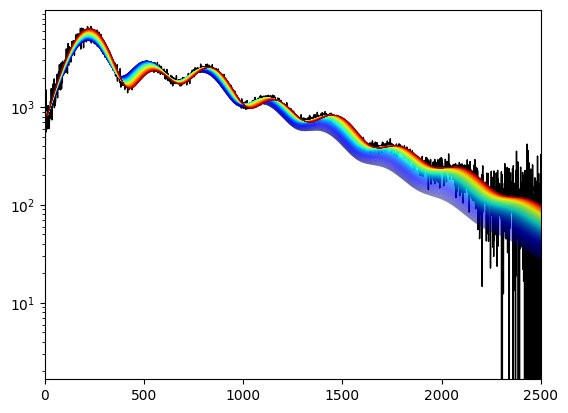

The Best Fitted input Value is 0.022099999999999925 having the chi^2 value is 121
1.4953250885009766
Total simulations of 200 Executed in : 1s 49 ms


In [4]:
start_time = time.time() #time calculation

pred_arr = [] #array of prediction [[],[],[]......]
chi2_arr = [] #array of chi2 values[,,,,,...]
input_range = np.arange(0.01,0.03,0.0001) #range

for val in input_range:    
    #params for cosmopower
    params = {'omega_b': [val],#0.02237],
              'omega_cdm': [0.1213],#1200],#0.47],#0.1200],
              'h': [66.943/100],#67.36,
              'tau_reio': [0.056101],#0.0544],
              'n_s': [0.9660],#0.83],#0.945],#0.964
              'ln10^{10}A_s': [np.log( 10**10 *(2.1069*1e-9) )],#3.629
              }
    DATA = 'TT' #'TE' or 'EE' or 'TT'
    if DATA == 'TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    else:
        print('Check DATA Input')



#plotting all the predicted curves
plt.clf()
color_arr = []
for d in np.linspace(0,255,len(input_range)):
    colr = plt.cm.jet(int(d))
    color_arr.append(colr)
if DATA == 'TT':
    plt.subplot(111,yscale='log')
    plt.xlim(0,2500)
    plt.plot(el,Dl_TT, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'TE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_TE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'EE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_EE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
else :
    print('Check DATA Input')


plt.show()

#finding the input value for the  minimum chi2 value
min_chi2 = np.argmin(chi2_arr) #position of minimum chi2
vals = input_range[min_chi2] #finding Input value of minimum chi2
total_values = np.shape(input_range)[0]# Number of values

print('The Best Fitted input Value is', vals,'having the chi^2 value is',min_chi2 )
end_time = time.time() #time calculation
print(end_time - start_time)
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Total simulations of',total_values,'Executed in :',tim)

TT params..
'omega_b':0.02210,
'omega_cdm':0.1205 ,
'h':67.29,
'tau_reio':0.0542,
'n_s':0.966,
'ln10^{10}A_s': [np.log( 10**10 *( 2.0969 ) )],

Recorded Vals
Parameters-------TT--------TE---------EE
Omega_b-------0.022271--0.02225----0.02222
Omega_cdm-----0.1211----0.1215-----0.1213
H-------------67.282----67.317-----66.943
Tau_Reio------0.05355---0.05593----0.56101
N_S-----------0.9667----0.960------0.9660
A_s-----------2.0961----2.909------2.1049
(0.022271,0.1211,67.282,0.05355,0.9667,2.0961)

In [10]:
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.021,0.023,0.00001)
omc = np.arange(0.11,0.13,0.0001)
h = np.arange(67,68,0.01)
tau = np.arange(0.05,0.06,0.00001)
ns = np.arange(0.9,1,0.001)
As = np.arange(2,2.2,0.0001)
rangee = [omb,omc,h,tau,ns,As]
paras = [0.0228,0.1208,67.29,0.0542,0.945,2.0969]
start_time = time.time() #time calculation
p_TT = loop_it('TT',rangee,paras,1) # direct calculations

for x in range(6):
    print(p_TT[0][x],'+-',p_TT[1][x])# looping for print
    
end_time = time.time() #time calculation
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Executed in :',tim)

0.022609999999999936 +- 0.0
0.12010000000000029 +- 0.0
67.31000000000016 +- 0.0
0.050790000000000245 +- 0.0
0.9560000000000001 +- 0.0
2.0860000000001815 +- 0.0
Executed in : 17s 39 ms


In [ ]:
#single parameter method
#print(Cosmo_Power('EE',0.0221,0.1205,67.29,0.0542,0.945,2.0969)[1])
omb = np.arange(0.021,0.023,0.00001)
omc = np.arange(0.11,0.13,0.0001)
h = np.arange(66.5,68,0.01)
tau = np.arange(0.05,0.06,0.00001)
ns = np.arange(0.9,0.95,0.0001)
As = np.arange(2,2.2,0.0001)
rangee = [omb,omc,h,tau,ns,As]
paras = [0.0221,0.1205,67.29,0.0542,0.945,2.0969]
start_time = time.time() #time calculation
source = []
sg_t = multiprocessing.Process(target=source.append(loop_it('TT',rangee,paras,1), args=(10, )))
#sg_te = multiprocessing.Process(target=loop_it('TE',rangee,paras,10), args=(10, ))
#sg_e = multiprocessing.Process(target=loop_it('EE',rangee,paras,10), args=(10, ))
sg_t.start()
#sg_te.start()
#sg_e.start()
sg_t.join()
#sg_te.join()
#sg_e.join()

end_time = time.time() #time calculation
tim = time_hr(end_time - start_time) # finding time for excution
print( 'Executed in :',tim)